# Monte Carlo Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing, os, sys, cProfile, pstats, io, traceback, time, random
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib.ticker import LogLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from functools import lru_cache
from joblib import Parallel, delayed
import warnings
from numba import jit, cuda 
warnings.filterwarnings("ignore")

# The full code

In [2]:
filepath = '/Users/AbSir/Desktop/cj22/CJ-code/fitpack/nucl/phi.wbarel_AV18'
gamma_list = []
y_list = []
f2_list = []
f0_list = []
print(f"Number of cores available: {multiprocessing.cpu_count()}")
with open(filepath, 'r') as file:
    for line in file:
        try:
            columns = [float(col) for col in line.split()]
            if len(columns) == 8:
                gamma_list.append(columns[0])
                y_list.append(columns[1])
                f2_list.append(columns[6])
                f0_list.append(columns[2])
        except:
            continue
gamma_array = np.array(gamma_list)
y_array = np.array(y_list)
f2_array = np.array(f2_list)
f0_array = np.array(f0_list)

results_cache = {}  # Dictionary to cache (avoid multiple computation)

def get_interpolator(gamma_fixed):
    # Check if the interpolator is already computed
    if gamma_fixed not in results_cache:
        mask = gamma_array == gamma_fixed
        y_filtered = y_array[mask]
        f0_filtered = f0_array[mask]
        results_cache[gamma_fixed] = interp1d(y_filtered, f0_filtered, kind='linear', fill_value='extrapolate')
    return results_cache[gamma_fixed]

def phi_int2d_fixed_gamma(y_D_grid, gamma_fixed):
    interpolator = get_interpolator(gamma_fixed)
    return interpolator(y_D_grid)

# This function is compiled Just-in-Time (JIT) by Numba to run on the GPU (cuda is a parallel computing platform by NVIDIA)
@jit(target_backend = 'cuda')
def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

@jit(target_backend = 'cuda')
def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def integrand(y_D_grid, x):
    f0 = phi_int2d_fixed_gamma(y_D_grid, gamma_fixed)
    f2 = f2_function(x, y_D_grid)
    return f2 * f0

def integrate_f2_f0(x_val):
    warnings.filterwarnings("ignore")
    f2dxd, error = quad(integrand, x_val, 1, args=(x_val,), points = [0.5])
    return f2dxd, error

# Importance sampling grid
y_D_grid = np.concatenate([np.linspace(0, 0.4, 200), np.linspace(0.4, 0.6, 300), np.linspace(0.6, 1, 200)])

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000)  # x_D values

# Parallel computation. n_jobs=-1 means using all available cores. The delayed function is a way to specify a computation without actually running it.
# This allows the Parallel object to run the computation in parallel.
results = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
integral_result_list, error_list = map(np.array, zip(*results))
simple_f2_list = f2nxn_function(x)
ratio = integral_result_list / simple_f2_list

Number of cores available: 8


# Plot it

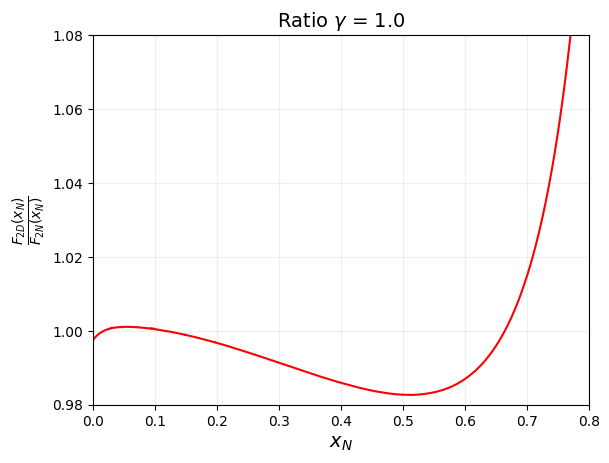

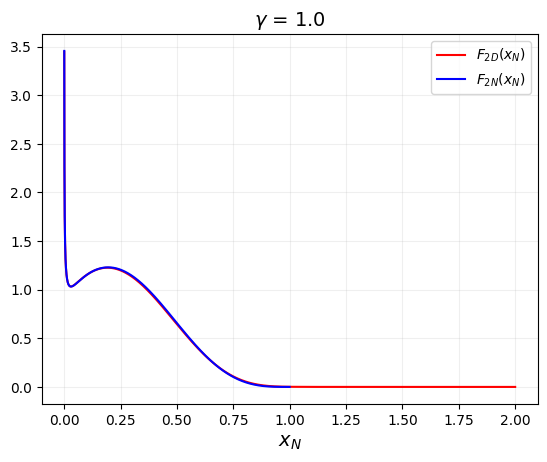

In [3]:
fig3, ax3 = plt.subplots()
x_N = x * 2
ax3.plot(x_N, ratio, 'r')
ax3.grid(alpha = 0.2)
ax3.set_xlabel(r'$x_N$', fontsize = 14)
ax3.set_ylabel(r'$\frac{F_{2D}(x_N)}{F_{2N}(x_N)}$', fontsize = 14)
ax3.set_title(fr'Ratio $\gamma$ = {gamma_fixed}', fontsize = 14)
ax3.set_xlim(0.0, 0.8)
ax3.set_ylim(0.98, 1.08)
# ax3.set_yscale('log')
fig3.savefig(f'plots/ratio_{time.time():.0f}.pdf')

fig2, ax2 = plt.subplots()
# ax2.plot(x, integral_result_list, 'r', label = r'$\int_{x_D}^1 dy_D f_0(y_D;\gamma)F_{2N}(x_D/y_D)$')
ax2.plot(x_N, integral_result_list, 'r', label = r'$F_{2D}(x_N)$')
ax2.plot(x_N, simple_f2_list, 'b', label = r'$F_{2N}(x_N)$')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
ax2.set_title(fr'$\gamma$ = {gamma_fixed}', fontsize = 14)
ax2.legend()
# fig2.savefig(f'plots/integral_{time.time():.0f}.pdf')

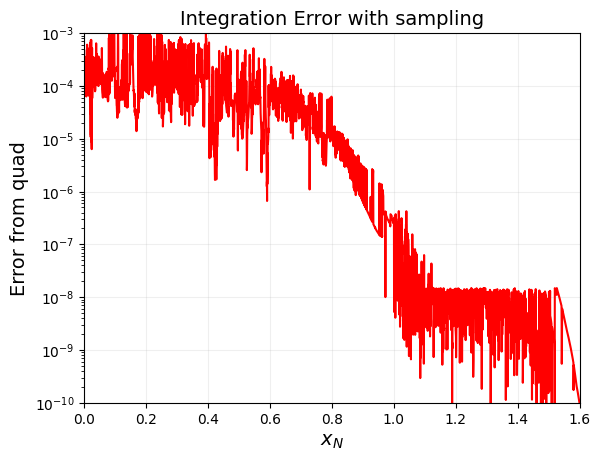

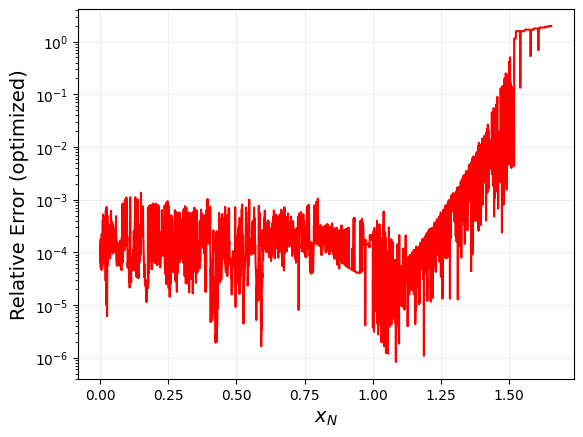

In [4]:
fig, ax = plt.subplots()
x_N = 2 * x
ax.plot(x_N, error_list, 'r')
ax.grid(alpha = 0.2)
ax.set_xlabel(r'$x_N$', fontsize = 14)
ax.set_ylabel('Error from quad', fontsize = 14)
ax.set_title('Integration Error with sampling', fontsize = 14)
ax.set_yscale('log')
ax.set_xlim(0, 1.6)
ax.set_ylim(1e-10, 1e-3)
# plt.savefig(f'plots/error_{time.time():.0f}.pdf')

relative_error = error_list / integral_result_list
fig2, ax2 = plt.subplots()
ax2.plot(x_N, relative_error, 'r')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
# ax2.set_title(fr'Relative Error', fontsize = 14)
ax2.set_ylabel('Relative Error (optimized)', fontsize = 14)
ax2.set_yscale('log')
fig2.savefig(f'plots/relative_error_{time.time():.0f}.pdf')